# Predicting Loan Repayment with Manual Feature Engineering

[Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is the process of creating new features (also called explanatory or predictor variables) out of an existing dataset to help a machine learning model learn a prediction problem. The objective of feature engineering is to extract as much useful information from a dataset as possible and it is [considered the most important step of the machine learning pipeline](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf) because a model can only learn from the data it is given!

In this notebook, we will walk through an application of traditional manual feature engineering to a machine learning task involving predicting whether or not a client will repay a loan. Manual feature engineering involves adding features by hand one at a time based on domain knowledge of the problem as illustrated below:

![](../../images/ManualFeatureEngineering.png)

After building a set of features, we can then use them for training a machine learning model and then making predictions. Feature engineering is a critical task, especially when we have datasets composed of multiple related tables.

## Feature Engineering Basics

Traditionally, [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is carried out by hand and involves using domain expertise to try and create predictor variables that are relevant to the specific problem. In many cases, data is spread across numerous related parent and child tables that are linked by specific variables. Because a machine learning model can only use a single table when training/predicting, feature engineering requires consolidating all the features into one table that has a single row for each observation with the columns containing the features. Once the data has been gathered into a single table (which we call the "base table"), a machine learning model can be trained on the training data and then assessed using a separate validation set or through cross-validation. 

While feature engineering is crucial to the success of a machine learning project, it can also be extremely tedious and time-consuming. Each feature is traditionally built one at a time which means one data scientist can only develop a limited number of features and there are numerous opportunities to make critical mistakes when implementing the code. Furthermore, the code required to make these features is problem specific which means the entire process must be _repeated for each new dataset_. In short, __manual feature engineering is time-consuming, error-prone, and is not transferable across problems.__ Moreover, __humans are limited both by time constraints and by creativity__ when it comes to designing new features. 

As a result, it is impossible to know when all the options for new features have been exhuasted and if the resulting set of features is as good as it could be. The space of features explored by a human will always be very small compared to the possible domain of features from any dataset. Throughout this notebook, keep in mind the inherent limitations of manual feature engineering, and in later notebooks we will explore an efficient alternative - automated feature engineering using [Featuretools](https://www.featuretools.com/) - that overcomes many of these drawbacks. 

## Roadmap

Our approach in this notebook will start at the ground level and build up. We will take a number of simple individual steps, explaining each one along the way:

1. One-hot encode categorical variables
2. Make a baseline model to establish a benchmark
3. Build domain knowledge features by manipulating columns of the base (main) dataframe 
4. Bring in information from child tables by grouping and aggregating statistics
    * Numeric features will be grouped and aggregated by parent ids
    * Categorical features will be one-hot encoded and then aggregated
5. Bring in information from _grandchild_ tables by grouping and aggregating statistics multiple times
    * Tables will be aggregated first at the parent level and then at the grandparent level
    * Categorical variables will also be included via one-hot encoding
6. Assess performance of new feature set in a machine learning model

Along the way, we will make visualizations to explore the data and see if the new features are of any value. Often, the only way to know for sure is to make a model without and then with the feature, but we can still use figures or correlations as a first-pass at assessing importance. 

## Problem and Dataset

The [Home Credit Default Risk competition](https://www.kaggle.com/c/home-credit-default-risk) currently running on Kaggle is a supervised classification task where the objective is to predict whether or not an applicant for a loan (known as a client) will default on the loan. The data comprises socio-economic indicators for the clients, loan specific financial information, and comprehensive data on previous loans at Home Credit (the institution sponsoring the competition) and other credit agencies. The metric for this competition is Receiver Operating Characteristic Area Under the Curve (ROC AUC) with predictions made in terms of the probability of default. We can evaluate our submissions both through cross-validation on the training data (for which we have the labels) or by submitting our test predictions to Kaggle to see where we place on the public leaderboard (which is calculated with only 10% of the testing data). 

The Home Credit Default Risk dataset ([available for download here](https://www.kaggle.com/c/home-credit-default-risk/data)) consists of seven tables of data:

* application_train/application_test: the main training/testing data for each client at Home Credit. The information includes both socioeconomic indicators for the client and loan-specific characteristics. Each loan has its own row and is uniquely identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 
* bureau: data concerning client's previous credits from other financial institutions (not Home Credit). Each previous credit has its own row in bureau, but one client in the application data can have multiple previous credits. The previous credits are uniquely identified by the feature `SK_ID_BUREAU`.
* bureau_balance: monthly balance data about the credits in bureau. Each row has information for one month about a previous credit and a single previous credit can have multiple rows. This is linked backed to the bureau loan data by `SK_ID_BUREAU` (not unique in this dataframe).
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each client in the application data can have multiple previous loans. Each previous application has one row in this dataframe and is uniquely identified by the feature `SK_ID_PREV`. 
* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans from the previous loan data. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows. This is linked backed to the previous loan data by `SK_ID_PREV` (not unique in this dataframe).
* credit_card_balance: monthly data about previous credit cards loans from the previous loan data. Each row is one month of a credit card balance, and a single credit card can have many rows. This is linked backed to the previous loan data by `SK_ID_PREV` (not unique in this dataframe).
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. This is linked backed to the previous loan data by `SK_ID_PREV` (not unique in this dataframe).

The image below shows the seven tables and the variables linking them:

![](../images/home_credit_data.png)

Feature engineering will require consolidating all of the data into a single table. For the prediction problem defined by the competition, all the features must be joined into the `application` table (known as `app`). In this table, there must be one row for every client (identified by `SK_ID_CURR`) with the columns containing the features. In training, we give the machine learning model both the features and the label in the hope that it can learn a generalizable mapping from features to label.

__We can make features both by manipulating (dividing, subtracting, etc.) columns of the `app` table and by incorporating information from the other tables using grouping, aggregating, and merging__. The only requirement is that we end with a single table (well, two tables, one for training and one for testing with the same columns in both) that has one row per client. 

# Application Main Data

Our first task will be to make features solely from the main dataframe `app`. It is possible to build a reasonably high-performance model from this data alone and we will work at enriching the information by manipulating columns (dividing, multiplying, etc.) based on domain knowledge. Each new feature will be built one at a time.

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

RSEED = 50

## One-Hot Encoding

Our first "feature engineering" step is to __one-hot encode__ all of the categorical variables. This is necessary because a machine learning model cannot handle string variables, and so we must create a separate binary column for each unique value of a categorical variable. The training and testing data must be aligned after one-hot encoding to ensure we have the same features in both datasets.

If we count one-hot encoding as feature engineering, then this step alone __generates 121 features__! Another option besides one-hot encoding is integer label encoding of categoricals. 

In [2]:
# Read in data
app_train = pd.read_csv('../input/application_train.csv')
app_test = pd.read_csv('../input/application_test.csv')

train_ids = list(app_train['SK_ID_CURR'])
test_ids = list(app_test['SK_ID_CURR'])

print('Original number of features: {}.'.format(app_train.shape[1] - 2))

# One Hot Encode
app_train, app_test = pd.get_dummies(app_train), pd.get_dummies(app_test)
app_test['TARGET'] = np.nan

# Align on the columns
app_train, app_test = app_train.align(app_test, axis = 1, join = 'inner')

original_features = list(app_train.columns)
original_features.remove('TARGET')
original_features.remove('SK_ID_CURR')

# Combine train/test into one dataset
app = app_train.append(app_test, sort=False)

print('Number of features after one-hot encoding: {}.'.format(app.shape[1] - 2))

Original number of features: 120.
Number of features after one-hot encoding: 241.


(One of the columns is the key, `SK_ID_CURR`, and one of the columns is the label, `TARGET`)

We join the training and testing data together to make sure that any operations we do to one set is repeated for the other set. The testing data can be extracted using `test = app[app["TARGET"].isnull()].copy()` and the training data by `train = app[app['TARGET'].notnull()].copy()`.

## Baseline Model 

Before doing any more feature engineering, it's important to establish a __baseline performance measure__. This will let us get a sense if feature engineering improves the model and by how much. Throughout this project, for our machine learning model, we will use the [Gradient Boosting Machine](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/), implemented in the [LightGBM library](http://lightgbm.readthedocs.io/en/latest/). 

For a baseline model, we will use the __default hyperparameter values__ and the initial set of features after one-hot encoding the `app` data. The number of estimators will be selected using early stopping for 100 rounds with 5-fold cross validation. This means that the number of estimators trained (`n_estimators` or `num_boost_rounds`) will be determined by the number of estimators that yields the highest performance metric as determined by 5-fold cross validation on the training data. Early stopping alleviates the need to choose the number of estimators and is an effective regularization technique for preventing overfitting to the training data.

Although using the default hyperparameter values is not a good choice for a final model, it will allow us to rapidly compare different feature sets. Keeping the same model will let us "isolate" the effect of adding the features as opposed to altering the model (later we will use random search to tune the models for a better comparison).

In [3]:
import lightgbm as lgb

test = app_test.drop(columns = ['TARGET', 'SK_ID_CURR'])

def cross_validate(train):
    """Compute cross validation ROC AUC of a gradient boosting model for a given training dataset"""
    
    # Extract the labels
    train_labels = np.array(train['TARGET'].astype(np.int32)).reshape((-1, ))
    train = train.drop(columns = ['TARGET', 'SK_ID_CURR'])

    # Create a  lgb training set
    train_set = lgb.Dataset(train, label = train_labels)

    # Find default hyperparameters
    model = lgb.LGBMClassifier()
    params = model.get_params()

    # Number of estimators will be selected through early stopping
    del params['n_estimators'], params['silent']

    # Early stoppping with 5 fold cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, metrics = 'auc', 
                        early_stopping_rounds = 100, seed = RSEED, nfold = 5)

    print('Cross Validation ROC AUC: {:.5f} with std: {:.5f}.'.format(cv_results['auc-mean'][-1],
                                                                               cv_results['auc-stdv'][-1]))

    print('Number of estimators trained: {}'.format(len(cv_results['auc-mean'])))
    
    return cv_results

In [4]:
cv_results_baseline = cross_validate(app_train)

Cross Validation ROC AUC: 0.75565 with std: 0.00604.
Number of estimators trained: 141


The baseline metric provides a good benchmark against which to measure any work we do. If we have nothing against which we can compare our feature engineering steps, then we cannot know if they are beneficial.

If we want to make submissions to the Kaggle competition, we can train a model on the training data using the "optimal" number of estimators from cross validation with early stopping (the length of the `cv_results`). Then we have the model make predictions which we save to a `csv` file for submission.

In [5]:
def make_submission(cv_results, train, test):
    """Make a submission dataframe for the Kaggle competition for a given dataset."""
    
    # Extract the labels
    train_labels = np.array(train['TARGET'].astype(np.int32)).reshape((-1, ))
    train = train.drop(columns = ['TARGET', 'SK_ID_CURR'])
    test_ids = list(test['SK_ID_CURR'])
    test = test.drop(columns = ['TARGET', 'SK_ID_CURR'])
    
    # Make model with optimal number of estimators and train on training data
    model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), random_state=RSEED)
    model.fit(train, train_labels)
    
    # Make predictions on the testing data
    preds = model.predict_proba(test)[:, 1]
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 
                                'TARGET': preds})
    
    return submission

In [6]:
submission_baseline = make_submission(cv_results_baseline, app_train, app_test)
submission_baseline.to_csv('../input/submission_baseline.csv', index = False)

These results can be uploaded to Kaggle for scoring. The public leaderboard on Kaggle is computed using 10% of the testing data (the full results on the entire testing data are made known at the end of the competition). This baseline model scores __0.741__ when submitted to the competition. For the final assessment, we can measure the performance of any new models relative to this baseline performance.

# Domain Knowledge Features

A large part of manual feature engineering involves trying to use domain knowledge in order to build features that are relevant for a particular problem. This can mean consulting experts or reading literature to find features that are applicable in a given field. For the Kaggle Home Credit Default Risk competition, [thousands of notebooks working with the data](https://www.kaggle.com/c/home-credit-default-risk/kernels) have been developed by a community of thousands of data scientists. These notebooks document useful features that have been constructed using domain knowledge and through trial and error and represent tens of thousands of hours spent on the problem. We can use the knowledge distilled in these kernels as well as our own ideas about what is likely to indicate whether or not a client will repay a loan to make features. This section relies on heavily on a number of kernels, most notably

* https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features
* https://www.kaggle.com/dromosys/fork-of-fork-lightgbm-with-simple-features-cee847

In addition to using domain features from these kernels, we will develop a number of our own features by reasoning about which factors might be important for determining whether or not a client will default on a loan. Each feature will be built __one at a time__ and while the ideas might be applicable across financial datasets, the code is not repeatable since it will be __specific to this problem__.

First, we will concentrate on using the `app` data. As an example of a feature from domain knowledge, we can find the interest rate of a loan. Although not given in the original data, this can be calculated by dividing the loan annuity, `AMT_ANNUITY`, by the total amount of the loan `AMT_CREDIT`. This may be useful because a higher risk loan will probably have a higher interest rate based on the client's financial history.

In [7]:
# Replace the anomalous values
app = app.replace({365243: np.nan})

# New features
app['LOAN_RATE'] = app['AMT_ANNUITY'] / app['AMT_CREDIT'] 
app['LOAN_RATE'].describe()

count    356219.000000
mean          0.055463
std           0.023206
min           0.022073
25%           0.038080
50%           0.050000
75%           0.067066
max           0.124430
Name: LOAN_RATE, dtype: float64

#### Explore New Feature

To get a sense of the distribution of this feature, we can make a [kernel density estimate plot](https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0). This shows the distribution of a single variable with the y-axis measured in _density_.

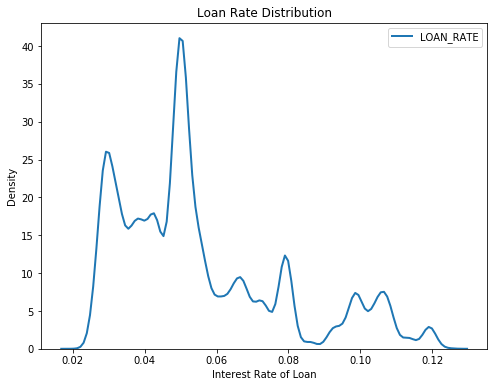

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Kdeplot of loan rate
plt.figure(figsize = (8, 6))
sns.kdeplot(app['LOAN_RATE'].dropna(), linewidth = 2);
plt.title('Loan Rate Distribution'); plt.xlabel('Interest Rate of Loan'); plt.ylabel('Density');

As a visual approximation of the relevance of this feature, we can color the kde plot by whether or not the loan was repaid (this only applies for the training data). We can also use the [Pearson correlation coefficient](http://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/) to measure a variable's correlation with the target. Although the correlation coefficient only measures linear relationships, it can serve as an approximation for which features may be important for a prediction problem. 

The following function can be used to plot the kde distribution of any feature colored by the value of the label, `TARGET` (whether or not the loan was repaid). It also prints out the correlation coefficient of the feature with the `TARGET`.

In [9]:
def kde_target(var_name, df):
    """Kernel density estimate plot of `var_name` colored by the value of the target.
       Also prints correlation coefficient and additional statistical information."""
    
    df = df.reset_index(drop = True).copy()
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name].dropna(), label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name].dropna(), label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    
    # Print out median values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

The correlation between LOAN_RATE and the TARGET is 0.0127
Median value for loan that was not repaid = 0.0500
Median value for loan that was repaid =     0.0500


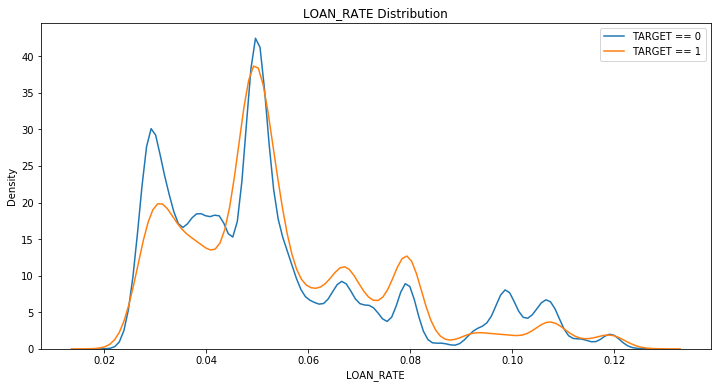

In [10]:
kde_target('LOAN_RATE', app[app['TARGET'].notnull()])

This variable does not appear to show much difference between those who repaid the loan and those who did not. Nonetheless, it is not possible to say if this variable will be "important" because there could be complex low-level interactions with other variables that combined are useful to the model. The only way to know for sure if a variable helps a model is to try modeling with and without the variable and see if it improves the cross-validation score. 

In [11]:
cv_results = cross_validate(app[app['TARGET'].notnull()])

Cross Validation ROC AUC: 0.76248 with std: 0.00658.
Number of estimators trained: 169


This feature alone increased our ROC AUC score in cross validation potentially indicating it is helpful. 

This process gave us one new feature that likely is relevant based on the cross validation score. Generally, we want to make as many features as possible in order to help the model. We can continue with this domain and literature based feature engineering process, trying to create new features that we think are important based on the problem. For manual feature engineering, we can continue adding features __as long as we have the stamina and the creativity to come up with new ideas!__ 

Next, we will add features that compare the total credit amount, `AMT_CREDIT`, to the total income, `AMT_INCOME_TOTAL`, and calculate the ratio of how long a client has been employed, `DAYS_EMPLOYED`, to their age, `DAYS_BIRTH` (these values are recorded relative to the current application so are negative). These are all features that have been developed by other community data scientists on Kaggle and are re-created here with their permission. 

In [12]:
app['CREDIT_INCOME_RATIO'] = app['AMT_CREDIT'] / app['AMT_INCOME_TOTAL']
app['EMPLOYED_BIRTH_RATIO'] = app['DAYS_EMPLOYED'] / app['DAYS_BIRTH']

In [13]:
app['CREDIT_INCOME_RATIO'].describe()

count    356255.000000
mean          3.849476
std           2.635035
min           0.004808
25%           2.000000
50%           3.158857
75%           5.000000
max          84.736842
Name: CREDIT_INCOME_RATIO, dtype: float64

The correlation between EMPLOYED_BIRTH_RATIO and the TARGET is -0.0680
Median value for loan that was not repaid = 0.0935
Median value for loan that was repaid =     0.1216


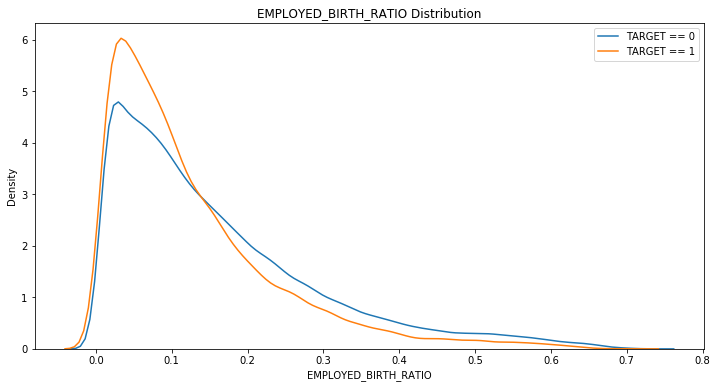

In [14]:
kde_target('EMPLOYED_BIRTH_RATIO', app[app['TARGET'].notnull()])

So far we have three new features from the application data. Next we can take a look at making new features from the `EXT_SOURCE_` and `AMT_REQ_` original features. The `EXT_SOURCE_` features (of which there are originally 3) are a credit score from external agencies. We will try to combine these in two different ways:

* EXT_SOURCE_SUM: add up the three scores
* EXT_SOURCE_MEAN: take the average of the three scores

The `AMT_REQ_` original features (of which there are originally 6) record "Number of enquiries to Credit Bureau about the client" at different periods before the current application. To create a new feature, we can add up all of these enquiries:

* AMT_REQ_SUM: sum of all the `AMT_REQ_` original features

With the `EXT_SOURCE_` features, we are basically creating our own composite credit score. Although we think this might be important to a client's potential to repay a loan, it's hard to know for sure if this will actually be useful in a model.

In [15]:
app['EXT_SOURCE_SUM'] = app[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].sum(axis = 1)
app['EXT_SOURCE_MEAN'] = app[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)

The correlation between EXT_SOURCE_MEAN and the TARGET is -0.2221
Median value for loan that was not repaid = 0.3991
Median value for loan that was repaid =     0.5338


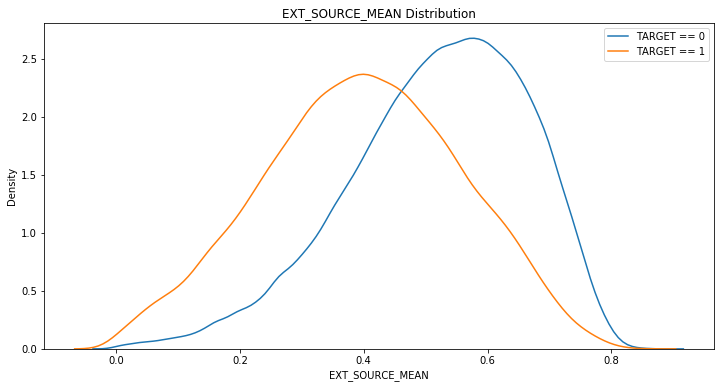

In [16]:
kde_target('EXT_SOURCE_MEAN', app[app['TARGET'].notnull()])

This feature looks like it might be helpful to the model since there is a significant difference in the distribution and median value between those who repaid their loan and those who did not. The idea behind these features are that if the `EXT_SOURCE_` variables come from different agencies, we can combine the knowledge together into one variable that captures all the information recorded in the scores. 

Again, it will be impossible to tell if these features are useful until we compare a model trained with and without these variables.

In [17]:
# Add up the `AMT_REQ_` columns
app['AMT_REQ_SUM'] = app[[x for x in app.columns if 'AMT_REQ_' in x]].sum(axis = 1)
app['AMT_REQ_SUM'].describe()

count    356255.000000
mean          2.157309
std           2.256242
min           0.000000
25%           0.000000
50%           2.000000
75%           3.000000
max         262.000000
Name: AMT_REQ_SUM, dtype: float64

Let's compute the cross validation score again to see if these features helped.

In [18]:
cv_results = cross_validate(app[app['TARGET'].notnull()])

Cross Validation ROC AUC: 0.76206 with std: 0.00611.
Number of estimators trained: 156


Including these features reduced the cross-validation score on our data! That's the tough part about feature engineering: even if our intuition says a given feature should help, that does not mean it will actually be useful. Moreover, we don't want to simply remove these features because it's possible they will be helpful if combined with future features that we make.

# Information from Other Tables

The six features created so far were all derived from a single source of data, the `app` dataframe. That leaves us with six other tables containing potentially useful information that we want to use for training our model. Using this data will require understanding how our tables are related. 

## Table Relationships

The easiest way to think of table relationships is the analogy between parent and child. A one-to-many table relationship is known as a parent-to-child relation because for each unique observation in the parent table, there can be many observations in the child table. For example, the `bureau` table is a child of the `app` table because for each client in `app`, there may be many previous loans at other institutions. 

In [19]:
bureau = pd.read_csv('../input/bureau.csv')
bureau.head(10)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   
5      215354       5714467        Active      currency 1         -273   
6      215354       5714468        Active      currency 1          -43   
7      162297       5714469        Closed      currency 1        -1896   
8      162297       5714470        Closed      currency 1        -1146   
9      162297       5714471        Active      currency 1        -1146   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   
5                   0              27460.0                NaN   
6                   0                 79.0                NaN   
7                   0              -1684.0            -1710.0   
8                   0               -811.0             -840.0   
9                   0               -484.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0        91323.00   
1                     NaN                   0       225000.00   
2                     NaN                   0       464323.50   
3                     NaN                   0        90000.00   
4                 77674.5                   0      2700000.00   
5                     0.0                   0       180000.00   
6                     0.0                   0        42103.80   
7                 14985.0                   0        76878.45   
8                     0.0                   0       103007.70   
9                     0.0                   0         4500.00   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                 0.00                   NaN                     0.0   
1            171342.00                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   
5             71017.38             108982.62                     0.0   
6             42103.80                  0.00                     0.0   
7                 0.00                  0.00                     0.0   
8                 0.00                  0.00                     0.0   
9                 0.00                  0.00                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN  
5      Credit card                 -31          NaN  
6  Consumer credit                 -22          NaN  
7  Consumer credit               -1710          NaN  
8  Consumer credit                -840          NaN  
9      Credit card                -690          NaN

The first client has 7 loans in this data indicating seven children for the single client (which are seven previous loans at other financial institutions). Parent and child tables are related by a shared variable, in this case the `SK_ID_CURR`. This variable must be unique for each individual in the parent table, but will occur many times (once for each child of the parent) in the child table. For these tables, the variable is named the same in both tables, but this is not necessarily always the case. We can link the tables using `SK_ID_CURR` and summarize the information from all of the children for each parent using groupings and aggregations. 

### Grouping and Aggregation

In order to summarize information from a child table for a parent, we have to group the children for each parent and then calculate aggregation statistics. An example is to group all the loans for a single client, and then calculate the average loan amount. This average would form a single new column in the parent dataframe with one observation of the variable for each parent. We have to use aggregations because the parent dataframe can only have one row per parent individual and so we have to capture all the information about the children in a single number (we can use multiple aggregations, but each one outputs only a single number for each parent). 

## Numeric Aggregations

To get started with grouping and aggregating, we will work on aggregating the numeric variables in the `bureau` dataframe. As one example of a feature we can make from a child table, we can count the number of previous loans at other credit institutions for each client.

In [20]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'PREVIOUS_OTHER_LOAN_COUNTS'})
previous_loan_counts.head()

SK_ID_CURR  PREVIOUS_OTHER_LOAN_COUNTS
0      100001                           7
1      100002                           8
2      100003                           4
3      100004                           2
4      100005                           3

### Merging

We then have to join this to the main `app` dataframe on the `SK_ID_CURR`. This is done with a `merge` operation where we use one or more variable to join observations from different tables.

In [21]:
app = app.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

The correlation between PREVIOUS_OTHER_LOAN_COUNTS and the TARGET is 0.0041
Median value for loan that was not repaid = 4.0000
Median value for loan that was repaid =     4.0000


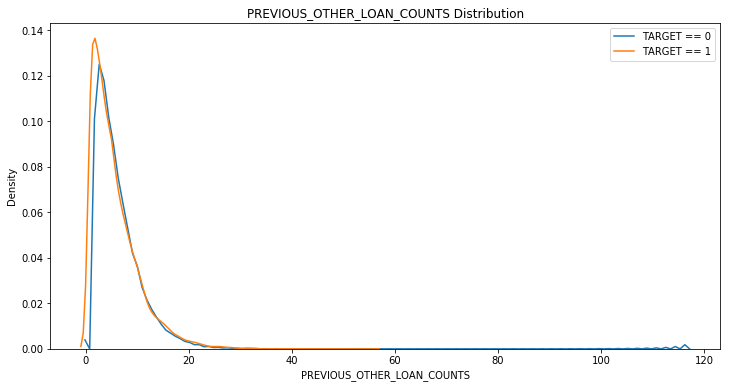

In [22]:
kde_target('PREVIOUS_OTHER_LOAN_COUNTS', app[app['TARGET'].notnull()])

This feature could be useful from a domain knowledge perspective because a larger number of previous loans might indicate a client who tended to repay their previous loans and hence received more loans. This is a proxy for a past credit history. 

This same general process: __grouping, aggregating, and merging__ can be used to build many new features from a child table. Here we will try to use domain knowledge to build more features such as the sum of the amount of previous loans. A client with a larger total of previous loan amounts might be more likely to repay or conversely, it could be a sign of a riskier client.

In [23]:
# Groupby the client id (SK_ID_CURR), sum the amounts for each previous loan and rename the resulting columns
previous_loan_sums = bureau.groupby('SK_ID_CURR', as_index=False)['AMT_CREDIT_SUM'].sum().rename(columns = {'AMT_CREDIT_SUM': 'PREVIOUS_OTHER_LOAN_SUM'})
app = app.merge(previous_loan_sums, on = 'SK_ID_CURR', how = 'left')
previous_loan_sums.head()

SK_ID_CURR  PREVIOUS_OTHER_LOAN_SUM
0      100001              1453365.000
1      100002               865055.565
2      100003              1017400.500
3      100004               189037.800
4      100005               657126.000

Since we made a rate for the loans in `app`, we can find the loan rate in `bureau`.

In [24]:
bureau['LOAN_RATE'] = bureau['AMT_ANNUITY'] / bureau['AMT_CREDIT_SUM']
bureau['LOAN_RATE'].describe()

count    4.810630e+05
mean              inf
std               NaN
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.365075e-02
max               inf
Name: LOAN_RATE, dtype: float64

There are many missing values or `inf` (indicating a divide by zero). 

We cannot yet merge this feature into `app` because it is still at the loan level, meaning there is one observation for every loan. We need to calculate one observation for every client, which requires an aggregation. Here we find the mean of previous loan rates for each client and then merge.

In [25]:
previous_loan_rate_mean = bureau.groupby('SK_ID_CURR', as_index=False)['LOAN_RATE'].mean().rename(columns = {'LOAN_RATE': 'PREVIOUS_OTHER_LOAN_RATE_MEAN'})
app = app.merge(previous_loan_rate_mean, on = 'SK_ID_CURR', how = 'left')
previous_loan_rate_mean['PREVIOUS_OTHER_LOAN_RATE_MEAN'].describe()

count    1.178090e+05
mean              inf
std               NaN
min      0.000000e+00
25%      3.333333e-03
50%      3.051528e-02
75%      9.287479e-02
max               inf
Name: PREVIOUS_OTHER_LOAN_RATE_MEAN, dtype: float64

## Categorical Children Variables

For the categorical variables in the parent data, we simply one-hot-encoded all of them to get a binary representation that can be used in a machine learning model. For the children tables, we can take a similar approach, but after the one-hot encoding, we will need to perform an aggregation to get one observation for each parent individual. 
As an example, we will focus on the `CREDIT_ACTIVE` feature in the `bureau` data. This could be an important feature because it indiciates the status of the previous loans at the time of application at Home Credit. 

First we one-hot-encode this feature to get a binary representation.

In [26]:
bureau_credit_active = pd.get_dummies(bureau[['SK_ID_CURR', 'CREDIT_ACTIVE']])
bureau_credit_active.head()

SK_ID_CURR  CREDIT_ACTIVE_Active  CREDIT_ACTIVE_Bad debt  \
0      215354                     0                       0   
1      215354                     1                       0   
2      215354                     1                       0   
3      215354                     1                       0   
4      215354                     1                       0   

   CREDIT_ACTIVE_Closed  CREDIT_ACTIVE_Sold  
0                     1                   0  
1                     0                   0  
2                     0                   0  
3                     0                   0  
4                     0                   0

There were four columns created by the one-hot encoding representing the four unique values of `CREDIT_ACTIVE`. We will use two of these, `CREDIT_ACTIVE_Active` and `CREDIT_ACTIVE_Closed`. We need to choose some form of aggregation to get one observation for each parent and here we will use sum. The resulting variables will represent the total observations of the particular value of `CREDIT_ACTIVE` across all of a client's previous loans at other institutions. 

In [27]:
bureau_credit_active_sums = bureau_credit_active.groupby('SK_ID_CURR', as_index = False)[['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Closed']].sum()
bureau_credit_active_sums = bureau_credit_active_sums.rename(columns = {'CREDIT_ACTIVE_Active': 'PREVIOUS_OTHER_CREDIT_ACTIVE_ACTIVE_SUM',
                                                                        'CREDIT_ACTIVE_Closed': 'PREVIOUS_OTHER_CREDIT_ACTIVE_CLOSED_SUM'})
bureau_credit_active_sums.head()

SK_ID_CURR  PREVIOUS_OTHER_CREDIT_ACTIVE_ACTIVE_SUM  \
0      100001                                        3   
1      100002                                        2   
2      100003                                        1   
3      100004                                        0   
4      100005                                        2   

   PREVIOUS_OTHER_CREDIT_ACTIVE_CLOSED_SUM  
0                                        4  
1                                        6  
2                                        3  
3                                        2  
4                                        1

This is now ready to be merged with the `app` data because there is one row for each client (one row per `SK_ID_CURR`).

In [28]:
app = app.merge(bureau_credit_active_sums, on = 'SK_ID_CURR', how = 'left')

### Previous Loans at Home Credit

We will now move on to domain-knowledge feature engineering working with the previous loans at Home Credit in the `previous` table. This is also a child of the `app` data so the process for extracting the data is much the same: group by the parent variable (`SK_ID_CURR`), perform an aggregation, and merge with the parent table on the parent variable. 

We will use several of the same features that we created from the previous loans at other instituions:

* PREVIOUS_LOAN_COUNTS
* PREVIOUS_LOAN_SUM
* PREVIOUS_LOAN_RATE_MEAN

Here we construct the three new features one at a time. 

In [29]:
previous = pd.read_csv('../input/previous_application.csv')
previous.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START            ...            NAME_SELLER_INDUSTRY  \
0                       15            ...                    Connectivity   
1                       11            ...                             XNA   
2                       11            ...                             XNA   
3                        7            ...                             XNA   
4                        9            ...                             XNA   

   CNT_PAYMENT  NAME_YIELD_GROUP       PRODUCT_COMBINATION  \
0         12.0            middle  POS mobile with interest   
1         36.0        low_action          Cash X-Sell: low   
2         12.0              high         Cash X-Sell: high   
3         12.0            middle       Cash X-Sell: middle   
4         24.0              high         Cash Street: high   

   DAYS_FIRST_DRAWING DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  \
0            365243.0          -42.0                     300.0          -42.0   
1            365243.0         -134.0                     916.0       365243.0   
2            365243.0         -271.0                      59.0       365243.0   
3            365243.0         -482.0                    -152.0         -182.0   
4                 NaN            NaN                       NaN            NaN   

  DAYS_TERMINATION NFLAG_INSURED_ON_APPROVAL  
0            -37.0                       0.0  
1         365243.0                       1.0  
2         365243.0                       1.0  
3           -177.0                       1.0  
4              NaN                       NaN  

[5 rows x 37 columns]

In [30]:
# Group by the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = previous.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(columns = {'SK_ID_PREV': 'PREVIOUS_LOAN_COUNTS'})
app = app.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

In [31]:
# Group by the client id (SK_ID_CURR), sum the amount of previous loans, and rename the column
previous_loan_sum = previous.groupby('SK_ID_CURR', as_index=False)['AMT_CREDIT'].count().rename(columns = {'AMT_CREDIT': 'PREVIOUS_LOAN_SUM'})
app = app.merge(previous_loan_sum, on = 'SK_ID_CURR', how = 'left')

In [32]:
# Calculate loan rate
previous['LOAN_RATE'] = previous['AMT_ANNUITY'] / previous['AMT_CREDIT']

# Calculate mean of loan rate for each client
previous_loan_rate_mean = previous.groupby('SK_ID_CURR', as_index=False)['LOAN_RATE'].mean().rename(columns = {'LOAN_RATE': 'PREVIOUS_LOAN_RATE_MEAN'})
app = app.merge(previous_loan_rate_mean, on = 'SK_ID_CURR', how = 'left')

We can take a look at two of the new features using the `kde_target` function.

The correlation between PREVIOUS_LOAN_RATE_MEAN and the TARGET is -0.0284
Median value for loan that was not repaid = 0.0993
Median value for loan that was repaid =     0.1027


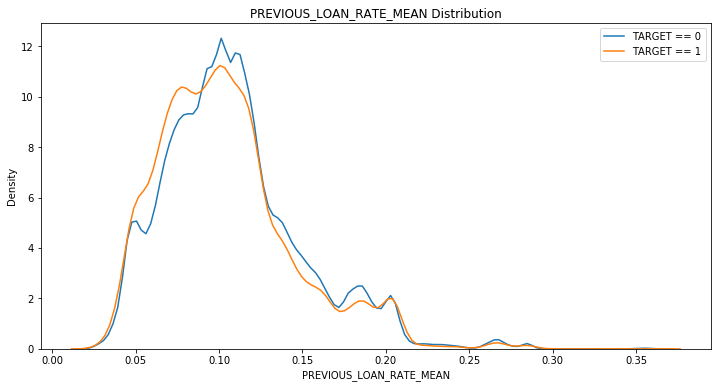

In [33]:
kde_target('PREVIOUS_LOAN_RATE_MEAN', app[app['TARGET'].notnull()])

The correlation between PREVIOUS_LOAN_SUM and the TARGET is 0.0198
Median value for loan that was not repaid = 4.0000
Median value for loan that was repaid =     4.0000


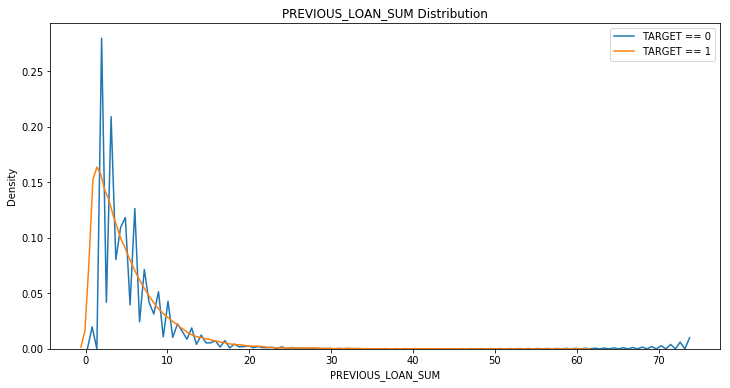

In [34]:
kde_target('PREVIOUS_LOAN_SUM', app[app['TARGET'].notnull()])

The final feature we will make from the `previous` table will be the mean of  `AMT_CREDIT` - `AMT_APPLICATION`. `AMT_CREDIT` is the actual amount of credit the applicant recieved while `AMT_APPLICATION` is the amount the client asked for. These can be different because Home Credit might give out a different credit amount than what the client requested. The difference between the requested amount and the awarded amount might be useful information. 

The correlation between PREVIOUS_LOAN_DIFFERENCE_MEAN and the TARGET is 0.0181
Median value for loan that was not repaid = 6727.5000
Median value for loan that was repaid =     4950.0000


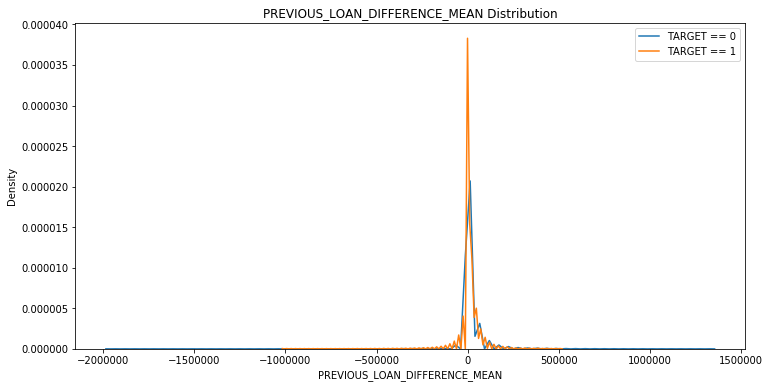

In [35]:
# Calculate difference
previous["AMT_DIFFERENCE"] = previous['AMT_CREDIT'] - previous['AMT_APPLICATION']
# Find the mean for each client
previous_difference_mean = previous.groupby('SK_ID_CURR', 
                                            as_index = False)['AMT_DIFFERENCE'].mean().rename(columns = {'AMT_DIFFERENCE': 'PREVIOUS_LOAN_DIFFERENCE_MEAN'})

app = app.merge(previous_difference_mean, on = 'SK_ID_CURR', how = 'left')
kde_target('PREVIOUS_LOAN_DIFFERENCE_MEAN', app[app['TARGET'].notnull()])

All of the preceding features were either made from the main dataframe or from children of the main dataframe. However, there are still more tables that are _grandchildren_ of the `app` data. These are linked to `app` via two steps and summarizing them will hence require at least two operations. In another notebook, we'll see how Featuretools can handle these tedious steps for us, but for now, we'll do it with the traditional manual method.

# Grandchild Tables

We have now used information from the two children tables, `previous` and `bureau`. There are still 4 more tables left that we want to incorporate into our final training data. These tables are not the direct children of `app` but instead are children of its children, or grandchildren tables. 

For example, the `bureau_balance` dataframe has monthly information about each loan in `bureau`. This makes `bureau_balance` the child of `bureau` and the grandchild of `app` . `bureau` is linked to `bureau_balance` by `SK_ID_BUREAU`, the parent variable for `bureau` which uniquely identifies each previous loan. Each `SK_ID_BUREAU` occurs once in `bureau` but potentially many times in `bureau_balance` for each month of the loan.

In [36]:
bureau_balance = pd.read_csv('../input/bureau_balance.csv')
bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

To use the grandchildren tables, we have to group and aggregate twice: first at the parent level and then at the grandparent level. If we have monthly information about each loan where each client has many previous loans, we have to aggregate the monthly information for each loan and then aggregate the loan information for each client. For instance, we could calculate the average monthly payment per loan, and then for all of a client's loans, calculate the maximum average monthly payment. This stat would be a single column in the final training dataframe with one observation for every client. You can imagine this is a tedious process.

We will first illustrate the general procedure using the `bureau_balance` dataframe. This has a column called `MONTHS_BALANCE` which represents the month of the balance relative to application date. First, we will aggregate this information at the loan level by finding the minimum `MONTHS_BALANCE` for each loan which represents the length of the loan. This time we have to group by `SK_ID_BUREAU` which identifies each loan.

In [37]:
previous_loan_length = bureau_balance.groupby('SK_ID_BUREAU', as_index = False)['MONTHS_BALANCE'].min().rename(columns = {'MONTHS_BALANCE': 'PREVIOUS_OTHER_LOAN_LENGTH'})
previous_loan_length.head()

SK_ID_BUREAU  PREVIOUS_OTHER_LOAN_LENGTH
0       5001709                         -96
1       5001710                         -82
2       5001711                          -3
3       5001712                         -18
4       5001713                         -21

Now we have to aggregate this at the client level by taking the mean across all of a client's loans. This means we first have to merge with the `bureau` data to get the `SK_ID_CURR` in the data.

In [38]:
previous_loan_length = previous_loan_length.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], 
                                                  on = 'SK_ID_BUREAU', how = 'left')

Then we calculate the mean `PREVIOUS_LOAN_LENGTH` for each client.

The correlation between PREVIOUS_OTHER_LOAN_LENGTH_MEAN and the TARGET is 0.0890
Median value for loan that was not repaid = -27.0000
Median value for loan that was repaid =     -33.6667


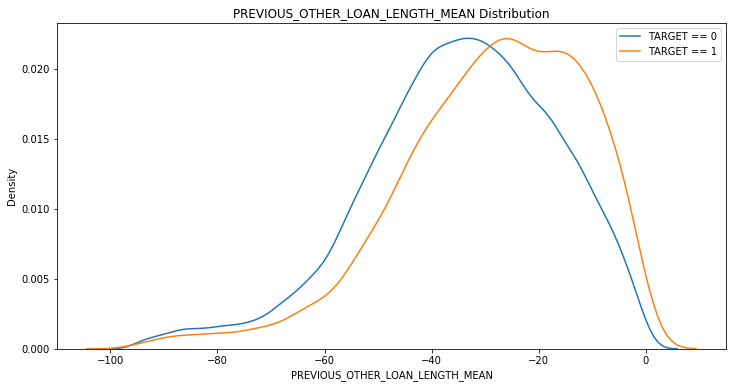

In [39]:
previous_loan_length_mean = previous_loan_length.groupby('SK_ID_CURR', as_index = False)['PREVIOUS_OTHER_LOAN_LENGTH'].mean()
previous_loan_length_mean = previous_loan_length_mean.rename(columns = {'PREVIOUS_OTHER_LOAN_LENGTH': 'PREVIOUS_OTHER_LOAN_LENGTH_MEAN'})
app = app.merge(previous_loan_length_mean, on = 'SK_ID_CURR', how = 'left')
kde_target('PREVIOUS_OTHER_LOAN_LENGTH_MEAN', app[app["TARGET"].notnull()])

This was a ton of work for a feature that might not even be useful! __We are starting to see that manual feature engineering is an extremely tedious and time-consuming process__. Moreover, this one feature is only good for this dataset. We can't apply it to other data without a lot of re-writing the code.

Since we already created the `PREVIOUS_LOAN_LENGTH`, we can also compute the sum in case that might be helpful. This feature represents the total length of all previous loans for a client.

In [40]:
previous_loan_length_sum = previous_loan_length.groupby('SK_ID_CURR', as_index = False)['PREVIOUS_OTHER_LOAN_LENGTH'].sum()
previous_loan_length_sum = previous_loan_length_sum.rename(columns = {'PREVIOUS_OTHER_LOAN_LENGTH': 'PREVIOUS_OTHER_LOAN_LENGTH_SUM'})
app = app.merge(previous_loan_length_sum, on = 'SK_ID_CURR', how = 'left')

### Grandchildren Categorical Variables

The grandchildren dataframes also have categorical variables such as `STATUS` in `bureau_balance`. To incorporate these in the grandparent dataframe, we will have to perform one-hot encoding and then two numeric aggregations.

In [41]:
bureau_balance_status = pd.get_dummies(bureau_balance[['SK_ID_BUREAU', 'STATUS']])
bureau_balance_status.head()

SK_ID_BUREAU  STATUS_0  STATUS_1  STATUS_2  STATUS_3  STATUS_4  STATUS_5  \
0       5715448         0         0         0         0         0         0   
1       5715448         0         0         0         0         0         0   
2       5715448         0         0         0         0         0         0   
3       5715448         0         0         0         0         0         0   
4       5715448         0         0         0         0         0         0   

   STATUS_C  STATUS_X  
0         1         0  
1         1         0  
2         1         0  
3         1         0  
4         1         0

A `STATUS` of `C` means closed, a status of `X` means unknown, a status of `0` means not past due, and a status of `1`-`5` indicates the number of periods overdue. For each loan, we can sum up the number of statuses that were not past due and the number of statuses that were past due. These could be useful features because they indicate whether a client paid their monthly payments on time for previous loans. 

The first step aggregations the categorical variable at the loan level.

In [42]:
previous_past_due = bureau_balance_status.groupby('SK_ID_BUREAU', as_index = False)[['STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5']].sum()
previous_past_due['PAST_DUE_SUM'] = previous_past_due[['STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5']].sum(axis = 1)
previous_past_due.head()

SK_ID_BUREAU  STATUS_1  STATUS_2  STATUS_3  STATUS_4  STATUS_5  \
0       5001709         0         0         0         0         0   
1       5001710         0         0         0         0         0   
2       5001711         0         0         0         0         0   
3       5001712         0         0         0         0         0   
4       5001713         0         0         0         0         0   

   PAST_DUE_SUM  
0             0  
1             0  
2             0  
3             0  
4             0

Now we have to aggregate this at the client level. To do so, we will merge with the bureau data to get the `SK_ID_CURR` and then take the sum of the `PAST_DUE_SUM`. The resulting feature represents the total number of past due months for all of a client's previous loans at other institutions.


The correlation between PREVIOUS_OTHER_PAST_DUE_SUM_SUM and the TARGET is 0.0248
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


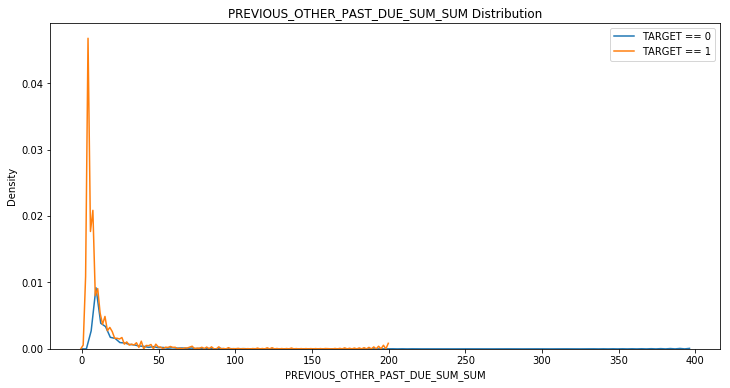

In [43]:
previous_past_due = previous_past_due.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on = 'SK_ID_BUREAU', how = 'left')
previous_past_due_sum = previous_past_due.groupby('SK_ID_CURR', as_index = False)['PAST_DUE_SUM'].sum().rename(columns = {'PAST_DUE_SUM': 'PREVIOUS_OTHER_PAST_DUE_SUM_SUM'})
app = app.merge(previous_past_due_sum, on = 'SK_ID_CURR', how = 'left')
kde_target('PREVIOUS_OTHER_PAST_DUE_SUM_SUM', app[app['TARGET'].notnull()])

Now we can do the same process but with the payments that were on time (`STATUS=0`).

In [44]:
# At the loan level
previous_on_time = bureau_balance_status.groupby('SK_ID_BUREAU', as_index = False)[['STATUS_0']].sum().rename(columns = {'STATUS_0': 'ON_TIME_SUM'})
previous_on_time = previous_on_time.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on = 'SK_ID_BUREAU', how = 'left')

# At the client level
previous_on_time_sum = previous_on_time.groupby('SK_ID_CURR', as_index = False)['ON_TIME_SUM'].sum().rename(columns = {'ON_TIME_SUM': 'PREVIOUS_OTHER_ON_TIME_SUM_SUM'})
previous_on_time_sum.head()

SK_ID_CURR  PREVIOUS_OTHER_ON_TIME_SUM_SUM
0    100001.0                            31.0
1    100002.0                            45.0
2    100005.0                            14.0
3    100010.0                            20.0
4    100013.0                            79.0

In [45]:
app = app.merge(previous_on_time_sum, on = 'SK_ID_CURR', how = 'left')

### Additional Grandchildren: Credit, Cash, Installments

Lets move on to the children of the `previous` dataframe. Two of these, `credit` and `cash`, capture monthly information on previous loans at Home Credit, while a third, `installments` records information about installment payments on the previous loans at Home Credit. These are all grandchildren of the main `app` table.

Since these are grandchildren tables of the `app` data, using them will again require two series of aggregations, first at the loan level and then at the client level. We will start with the `installments` data.

In [46]:
installments = pd.read_csv('../input/installments_payments.csv')
installments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

We can use the `DAYS_INSTALMENT` and the `DAYS_ENTRY_PAYMENT` to figure out if the payment was late. If the `DAYS_ENTRY_PAYMENT` is less negative than `DAYS_INSTALMENT`, then this indicates a late payment since the time is measured relative to the application of the current loan. We will create a binary column indicating whether an installment was late or not. 

In [47]:
# Column indicating whether or not a payment was late
installments['LATE'] = installments['DAYS_ENTRY_PAYMENT'] > installments['DAYS_INSTALMENT']
installments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT   LATE  
0          -1180.0             -1187.0        6948.360     6948.360  False  
1          -2156.0             -2156.0        1716.525     1716.525  False  
2            -63.0               -63.0       25425.000    25425.000  False  
3          -2418.0             -2426.0       24350.130    24350.130  False  
4          -1383.0             -1366.0        2165.040     2160.585   True

Now we need to aggregate this twice to get the information into `app`. We will use two different strategies: take the mean at the loan level and then the mean at the client level. This represents the average percentage of late payments for a client of the average percentage of late payments for each loan. The other method will be the sum at the loan level and then the sum at the client level. This represents the total late payments for all loans of a client. 

In [48]:
# Loan level
installments_late_mean = installments.groupby('SK_ID_PREV', as_index = False)['LATE'].mean()
installments_late_mean = installments_late_mean.merge(previous[['SK_ID_PREV', 'SK_ID_CURR']], 
                                                      on = 'SK_ID_PREV', how = 'left')

# Client level
installments_late_mean_mean = installments_late_mean.groupby('SK_ID_CURR', as_index = False)['LATE'].mean().rename(columns = {'LATE': 'INSTALLMENTS_LATE_MEAN_MEAN'})
app = app.merge(installments_late_mean_mean, on = 'SK_ID_CURR', how = 'left')

In [49]:
# Loan level
installments_late_sum = installments.groupby('SK_ID_PREV', as_index = False)['LATE'].sum()
installments_late_sum = installments_late_sum.merge(previous[['SK_ID_PREV', 'SK_ID_CURR']], 
                                                      on = 'SK_ID_PREV', how = 'left')

# Client level
installments_late_sum_sum = installments_late_sum.groupby('SK_ID_CURR', as_index = False)['LATE'].sum().rename(columns = {'LATE': 'INSTALLMENTS_LATE_SUM_SUM'})
app = app.merge(installments_late_sum_sum, on = 'SK_ID_CURR', how = 'left')

The correlation between INSTALLMENTS_LATE_SUM_SUM and the TARGET is 0.0336
Median value for loan that was not repaid = 1.0000
Median value for loan that was repaid =     1.0000


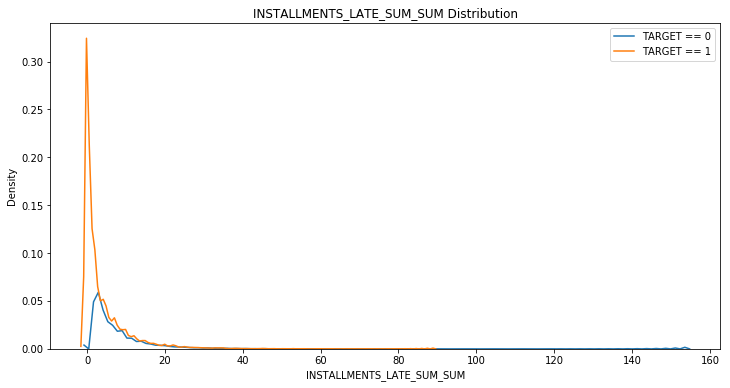

In [50]:
kde_target('INSTALLMENTS_LATE_SUM_SUM', app[app["TARGET"].notnull()])

The `installments` table also has features called `AMT_INSTALMENT` and `AMT_PAYMENT` which we can use to figure out if the payment was under the required amount. If `AMT_PAYMENT` is less than `AMT_INSTALMENT`, then the payment was low. 

We can then aggregate this feature twice (using the sum and the sum, and the mean and the mean) to get the data into the `app` table.

In [51]:
# Create a column indicating if payment was under the prescribed amount
installments['UNDER'] = installments['AMT_PAYMENT'] < installments['AMT_INSTALMENT']

# Mean of mean of under payments
# Loan level
installments_under_mean = installments.groupby('SK_ID_PREV', as_index = False)['UNDER'].mean()
installments_under_mean = installments_under_mean.merge(previous[['SK_ID_PREV', 'SK_ID_CURR']], 
                                                      on = 'SK_ID_PREV', how = 'left')

# Client level
installments_under_mean_mean = installments_under_mean.groupby('SK_ID_CURR', as_index = False)['UNDER'].mean().rename(columns = {'UNDER': 'INSTALLMENTS_UNDER_MEAN_MEAN'})
app = app.merge(installments_under_mean_mean, on = 'SK_ID_CURR', how = 'left')

# Sum of sum of under payments
# Loan level
installments_under_sum = installments.groupby('SK_ID_PREV', as_index = False)['UNDER'].sum()
installments_under_sum = installments_under_sum.merge(previous[['SK_ID_PREV', 'SK_ID_CURR']], 
                                                      on = 'SK_ID_PREV', how = 'left')

# Client level
installments_under_sum_sum = installments_under_sum.groupby('SK_ID_CURR', as_index = False)['UNDER'].sum().rename(columns = {'UNDER': 'INSTALLMENTS_UNDER_SUM_SUM'})
app = app.merge(installments_under_sum_sum, on = 'SK_ID_CURR', how = 'left')

The correlation between INSTALLMENTS_UNDER_SUM_SUM and the TARGET is 0.0304
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


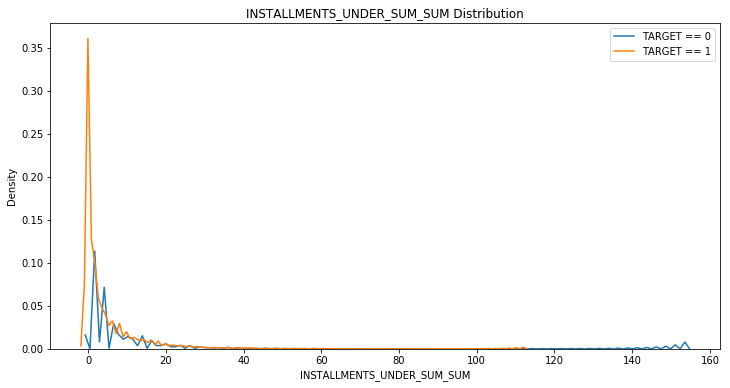

In [52]:
kde_target('INSTALLMENTS_UNDER_SUM_SUM', app[app['TARGET'].notnull()])

For all of these features, there are a high percentage of missing values because many of the clients do not have information on previous loans. 

We will make one more feature from the `installments` data: the total number of installments for a client. For this feature, we can simply group by the `SK_ID_CURR` and count the number of entries in `installments`. This represents the number of previous payments across all of a client's previous loans.

In [53]:
installment_counts = installments.groupby('SK_ID_CURR', as_index = False)['SK_ID_PREV'].count().rename(columns = {'SK_ID_PREV': 'INSTALLMENTS_COUNT'})
app = app.merge(installment_counts, on = 'SK_ID_CURR', how = 'left')

Lets take a quick look at how many features we have built.

In [54]:
print('Built {} features so far.'.format(app.shape[1] - len(original_features) - 2))

Built 24 features so far.


#### Evaluate Feature Set

Let's also look at the cross validation performance. The best we achieved thus far was 0.76206.

In [55]:
cv_results = cross_validate(app[app['TARGET'].notnull()])

Cross Validation ROC AUC: 0.76984 with std: 0.00517.
Number of estimators trained: 178


The cross validation score has now increased beyond that from only working with the `app` data. We saw a decrease after adding in the previous features, but now an increase indicating these features might be beneficial to the model when combined together rather than separately. It's hard to isolate the effect of any one feature when adding mutliple features at a time and we could also re-assess the model based on each feature.

We will move on from the installments data to the other two children of the `previous` data. We'll start with the `credit` data which has monthly information on credit card loans. 

In [56]:
credit = pd.read_csv('../input/credit_card_balance.csv')
credit.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY     ...      AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325     ...              0.000                 0.000   
1                 2250.000     ...          64875.555             64875.555   
2                 2250.000     ...          31460.085             31460.085   
3                11795.760     ...         233048.970            233048.970   
4                22924.890     ...         453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

For this data, we will find the average loan balance `AMT_BALANCE` for each client of the average loan balance per loan and the average loan length using the `MONTHS_BALANCE`. Here the code we are using is nearly the same as for other tables, but we still have to re-write it to change the variable names.

In [57]:
# Loan level
credit_balance_mean = credit.groupby('SK_ID_PREV', as_index = False)["AMT_BALANCE"].mean()
credit_balance_mean = credit_balance_mean.merge(credit[['SK_ID_CURR', 'SK_ID_PREV']], 
                                                on = 'SK_ID_PREV', how = 'left')

# Client level
credit_balance_mean_mean = credit_balance_mean.groupby('SK_ID_CURR', as_index = False)["AMT_BALANCE"].mean().rename(columns = {"AMT_BALANCE": "CREDIT_CARD_AMT_BALANCE_MEAN_MEAN"})
app = app.merge(credit_balance_mean_mean, on = 'SK_ID_CURR', how = 'left')

In [58]:
# Loan level
credit_loan_length = credit.groupby('SK_ID_PREV', as_index = False)['MONTHS_BALANCE'].min()
credit_loan_length = credit_loan_length.merge(credit[['SK_ID_CURR', 'SK_ID_PREV']], 
                                                on = 'SK_ID_PREV', how = 'left')

# Client level
credit_loan_length_mean = credit_loan_length.groupby('SK_ID_CURR', as_index = False)['MONTHS_BALANCE'].mean().rename(columns = {'MONTHS_BALANCE': 'CREDIT_CARD_AVERAGE_LOAN_LENGTH'})
app = app.merge(credit_loan_length_mean, on = 'SK_ID_CURR', how = 'left')

The correlation between CREDIT_CARD_AVERAGE_LOAN_LENGTH and the TARGET is 0.0615
Median value for loan that was not repaid = -17.0000
Median value for loan that was repaid =     -23.0000


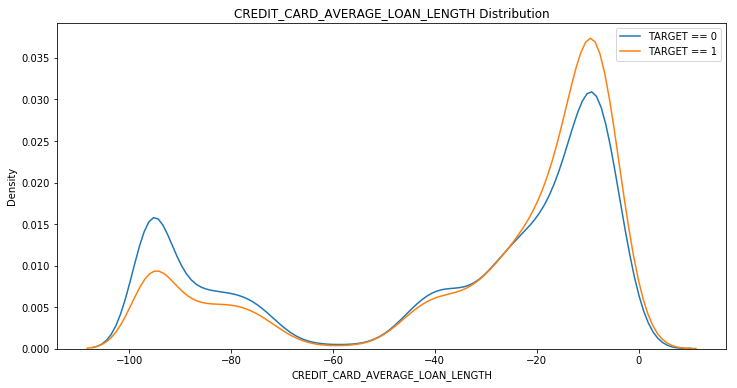

In [59]:
kde_target('CREDIT_CARD_AVERAGE_LOAN_LENGTH', app[app['TARGET'].notnull()])

The final data table, `cash` represents the cash loans. This has a column called `SK_DPD` which represents the days past due of the monthly balance. We can make two new features out of this column, the mean at the client level of the mean at the loan level, and the sum at the client level of the sum at the loan level.

In [60]:
cash = pd.read_csv('../input/POS_CASH_balance.csv')
cash.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [61]:
# Loan level
cash_dpd_sum = cash.groupby('SK_ID_PREV', as_index = False)['SK_DPD'].sum()
cash_dpd_sum = cash_dpd_sum.merge(credit[['SK_ID_CURR', 'SK_ID_PREV']], 
                                                on = 'SK_ID_PREV', how = 'left')

# Client level
cash_dpd_sum_sum = cash_dpd_sum.groupby('SK_ID_CURR', as_index = False)['SK_DPD'].sum().rename(columns = {"SK_DPD": "CASH_DPD_SUM_SUM"})
app = app.merge(cash_dpd_sum_sum, on = 'SK_ID_CURR', how = 'left')

In [62]:
# Loan level
cash_dpd_mean = cash.groupby('SK_ID_PREV', as_index =False)['SK_DPD'].mean()
cash_dpd_mean = cash_dpd_mean.merge(credit[['SK_ID_CURR', 'SK_ID_PREV']], 
                                                on = 'SK_ID_PREV', how = 'left')

# Client level
cash_dpd_mean_mean = cash_dpd_mean.groupby('SK_ID_CURR', as_index = False)['SK_DPD'].mean().rename(columns = {"SK_DPD": "CASH_DPD_MEAN_MEAN"})
app = app.merge(cash_dpd_mean_mean, on = 'SK_ID_CURR', how = 'left')

For this data we can also find the total counts for each client, and the average length of loan.

In [63]:
# Count number of previous loans 
cash_counts = cash.groupby('SK_ID_CURR', as_index = False)['SK_ID_PREV'].count().rename(columns = {'SK_ID_PREV': 'CASH_COUNTS'})
app = app.merge(cash_counts, on = 'SK_ID_CURR', how = 'left')

In [64]:
# Loan level
cash_loan_length = cash.groupby('SK_ID_PREV', as_index = False)['MONTHS_BALANCE'].min()
cash_loan_length = cash_loan_length.merge(cash[['SK_ID_CURR', 'SK_ID_PREV']], 
                                                on = 'SK_ID_PREV', how = 'left')

# Client level
cash_loan_length_mean = cash_loan_length.groupby('SK_ID_CURR', as_index = False)['MONTHS_BALANCE'].mean().rename(columns = {'MONTHS_BALANCE': 'CASH_AVERAGE_LOAN_LENGTH'})
app = app.merge(cash_loan_length_mean, on = 'SK_ID_CURR', how = 'left')

# Manual Feature Engineering Results

There is nothing stopping us from making even more features except our patience and imagination! At this point, we have built 30 features __one at a time__. This is extremely tedious, error-prone, time-consuming, and problem specific. There is no way to translate this code to another problem because it is explictly hard-coded to the data for the Home Credit competition. All of the time we have spent on this problem will not be useful for any other problem which seems a little inefficient. 

After making all of these features, we need to find out how much, if any, they have helped us. 

In [65]:
print('Built {} features.'.format(app.shape[1] - len(original_features) - 2))

Built 30 features.


## Validating New Features

After building the new features, we can make another model in order to determine if the features have improved the cross validation ROC AUC or the competition score. Again, we will use early stopping with 5-fold cross validation to determine the number of estimators to train. 

In [66]:
# Extract the training and testing data
app_new_train, app_new_test = app[app['TARGET'].notnull()], app[app['TARGET'].isnull()]

# Cross validate with the new data
cv_results = cross_validate(app_new_train)

Cross Validation ROC AUC: 0.77227 with std: 0.00503.
Number of estimators trained: 142


Our cross-validation score has improved from the baseline model and from the intermediate sets of features. This should give us confidence that our feature engineering was worthwhile. Let's save the features so we can use them later.

__This shows us that feature engineering is indeed useful because it can significantly improve performance. We ended up with a better model after a significant time investment.__

In [67]:
app.to_csv('../input/features_manual_domain.csv', index = False)

## Feature Importances

With a tree-based model such as the Gradient Boosted Machine, we can find what are known as the feature importances which measure how relevant features are to the model. These are helpful not on an absolute scale ([they measure the reduction in impurity from including the feature in the model](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined)) but on a relative scale to compare which features are more useful than others to a machine learning model. 

We have to train a new model on the data in order to extract the feature importances (`cv` does not allow us to see feature importances).

In [68]:
train_labels = np.array(app_new_train['TARGET'].astype(np.int32)).reshape((-1,))
app_new_train = app_new_train.drop(columns = ['SK_ID_CURR', 'TARGET'])

# New model fit on the training data
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), random_state = RSEED)
model.fit(app_new_train, train_labels)

# Put feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': list(app_new_train.columns), 
                                    'importance': model.feature_importances_})

feature_importances.head()

feature  importance
0      CNT_CHILDREN           4
1  AMT_INCOME_TOTAL          41
2        AMT_CREDIT          72
3       AMT_ANNUITY          90
4   AMT_GOODS_PRICE          68

Let's write a short function to visualize the feature importances.

In [69]:
def plot_feature_importances(df):
    """
    Plots 15 most important features and returns a sorted feature importance dataframe.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance

        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    
    return df

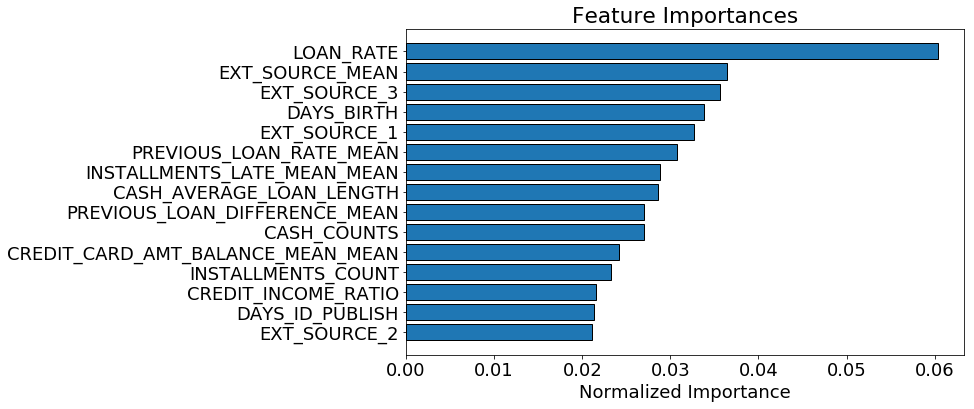

index                        feature  importance  importance_normalized  \
0    241                      LOAN_RATE         257               0.060329   
1    245                EXT_SOURCE_MEAN         155               0.036385   
2     29                   EXT_SOURCE_3         152               0.035681   
3      6                     DAYS_BIRTH         144               0.033803   
4     27                   EXT_SOURCE_1         139               0.032629   
5    254        PREVIOUS_LOAN_RATE_MEAN         131               0.030751   
6    260    INSTALLMENTS_LATE_MEAN_MEAN         123               0.028873   
7    270       CASH_AVERAGE_LOAN_LENGTH         122               0.028638   
8    255  PREVIOUS_LOAN_DIFFERENCE_MEAN         115               0.026995   
9    269                    CASH_COUNTS         115               0.026995   

   cumulative_importance  
0               0.060329  
1               0.096714  
2               0.132394  
3               0.166197  
4               0.198826  
5               0.229577  
6               0.258451  
7               0.287089  
8               0.314085  
9               0.341080

In [70]:
norm_fi = plot_feature_importances(feature_importances)
norm_fi.head(10)

We can see that some of our features made it into the most important! That gives us some confidence that feature engineering was worthwhile. We even see that one of our features, the `LOAN_RATE`, achieved the highest importance of any feature. However, even though these features are important, they came at a very high price in terms of time invested. 

### Correlations of Features with the Label

We can also calculate the correlation of all the features with the target to see if there are any significant relationships. Although this is not the best measure for the importance of a feature, it can be an approximation of which features may be useful for the prediction problem.

In [71]:
# Calculate all correlations
corrs = app[app['TARGET'].notnull()].corr().sort_values('TARGET')

In [72]:
# Most negative correlations
corrs['TARGET'].dropna().head()

EXT_SOURCE_MEAN   -0.222052
EXT_SOURCE_3      -0.178919
EXT_SOURCE_SUM    -0.173322
EXT_SOURCE_2      -0.160472
EXT_SOURCE_1      -0.155317
Name: TARGET, dtype: float64

In [73]:
# Most positive correlations
corrs['TARGET'].dropna().tail()

DAYS_EMPLOYED                        0.074958
DAYS_BIRTH                           0.078239
CREDIT_CARD_AMT_BALANCE_MEAN_MEAN    0.087177
PREVIOUS_OTHER_LOAN_LENGTH_MEAN      0.089036
TARGET                               1.000000
Name: TARGET, dtype: float64

One of our features `EXT_SOURCE_MEAN`, has the greatest absolute correlation with the target. This, taken together with the feature importances from the model, should give us confidence that at least some of the features we build by hand were important. 

In [78]:
manual_zero_importance = feature_importances.loc[~(feature_importances['feature'].isin(original_features)) & (feature_importances['importance'] == 0.0), 'feature'].copy()
print('{} of the manual features have zero importance.\n'.format(len(manual_zero_importance)))
print(manual_zero_importance)

3 of the manual features have zero importance.

253     PREVIOUS_LOAN_SUM
267      CASH_DPD_SUM_SUM
268    CASH_DPD_MEAN_MEAN
Name: feature, dtype: object


3 of the manual engineered features have zero importance meaning they can be removed from this model with no decrease in performance. 

In [82]:
preds = model.predict_proba(app_new_test.drop(columns = ['SK_ID_CURR', 'TARGET']))[:, 1]
new_submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': preds})
new_submission.to_csv('../input/manual_submission.csv', index = False)

Submitting these predictions to the competition results in a public leaderboard ROC AUC of __0.786.__

# Conclusions 

My conservative estimate is that I spent a total of __10 hours making these features__! Morevoer, that was only after reading through many notebooks where other data scientists had documented their work representing hundreds of total hours of labor. In short, manual feature engineering is a time-intensive process. 

Also, while the _concepts_ we used here can be applied to other problems, _the code is extremely dataset-specific_ and would have to be re-written to apply to other datasets. While manual feature engineering was tedious, we saw that feature engineering is necessary and the new features did improve the cross-validation score and were some of the most important predictor variables according to a machine learning model. The final metrics from manual feature engineering are:


| Dataset                     	| Total Features 	| Time Spent (conservative estimate) 	| CV ROC AUC 	| Public Leaderboard ROC AUC 	|
|-----------------------------	|----------------	|------------------------------------	|------------	|----------------------------	|
| Main after one-hot encoding 	| 241            	| 15 minutes                         	| 0.75565    	| 0.741                      	|
| Manual Feature Engineering  	| 271            	| 10 hours 	| 0.77227    	| 0.786                      	|

Our main takeaways from the manual feature engineering are:

* Feature engineering is crucial because it can significantly improve the predictive performance of a machine learning model
* Manual feature engineering is time-intensive, error-prone, and completely problem-specific
* Using domain knowledge resulted in features important to the gradient boosting machine and improved cv ROC AUC
* We are only limited in the number of features we build by time and creativity

So, we know two things: __feature engineering is important, and the traditional manual approach is extremely costly.__ A logical next step is to ask if there are other methods for feature engineering? The answer, fortunately, is yes: there are more efficient methods that we can use. 

In future notebooks, we will implement both semi-automated feature engineering and fully automated feature engineering using Featuretools. These methods can allow us to rapidly create hundreds or thousands of features and can even build on top of our domain knowledge. While these methods will not replace the data scientist, they will allow her to build a more efficient pipeline with less of the tedium of manual feature engineering. Data science is about constantly re-learning the best tool for a task, and while manual feature engineering is an effective method, there are more efficient methods to achieve the same or better performance at a fraction of the time investment.